In [1]:
#Include Libraries:
import tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
#Read CSV Files
dataset_dir = "./Dataset/"
chotot_dataset = pd.read_csv(dataset_dir + "chotot.csv",index_col = [0])
phongtro123_dataset = pd.read_csv(dataset_dir + "phongtro123.csv",index_col=[0])
print(phongtro123_dataset.head())
print(chotot_dataset.head())

       Price  Area            Ward     District
0  1300000.0    20        Hòa Minh   Liên Chiểu
1  3000000.0    25   Nại Hiên Đông      Sơn Trà
2  1500000.0    15         Hòa Khê    Thanh Khê
3  2600000.0    30      An Hải Bắc      Sơn Trà
4  3200000.0    40   Hòa Khánh Nam   Liên Chiểu
     Price  Area  Deposit Fee        Furniture           Ward     District
0  1600000    20     500000.0              NaN   Hòa Thọ Đông       Cẩm Lệ
1  1100000    40      50000.0  Nội thất đầy đủ    Thuận Phước     Hải Châu
2  1500000    20     500000.0        Nhà trống       Hòa Phát       Cẩm Lệ
3  2500000    25    2500000.0  Nội thất đầy đủ       Hòa Minh   Liên Chiểu
4  1200000    30    1000000.0  Nội thất đầy đủ    Thuận Phước     Hải Châu


In [3]:
#Preparing Dataset for Feature Engineering
chotot_dataset = chotot_dataset.drop(columns=['Deposit Fee'])
Dataset = pd.concat([chotot_dataset, phongtro123_dataset])
print(Dataset.shape)
Dataset.head()

(1654, 5)


,Price,Area,Furniture,Ward,District
0,1600000.0,20,NaN,Hòa Thọ Đông,Cẩm Lệ
1,1100000.0,40,Nội thất đầy đủ,Thuận Phước,Hải Châu
2,1500000.0,20,Nhà trống,Hòa Phát,Cẩm Lệ
3,2500000.0,25,Nội thất đầy đủ,Hòa Minh,Liên Chiểu
4,1200000.0,30,Nội thất đầy đủ,Thuận Phước,Hải Châu


In [4]:
#Checking Nan values in Dataset
Dataset.isna().sum()

Price          20
Area            0
Furniture    1213
Ward          103
District       36
dtype: int64

In [5]:
#Splitting Continous and Categorical columns
Categorical_cols = ['Ward','District','Furniture']
Continous_cols = ['Area']

In [6]:
#Filling Nan values in these feature columns
Dataset = Dataset[Dataset['Price'].notna()]
Dataset.Furniture.fillna(value = "Nhà trống", inplace = True)
Dataset.Ward.fillna(value = "Unknown W", inplace = True)
Dataset.District.fillna(value = "Unknown D", inplace = True)
Dataset.isna().sum()

Price        0
Area         0
Furniture    0
Ward         0
District     0
dtype: int64

In [7]:
#Using Onehot Encoding in Categorical Columns
ohe = OneHotEncoder(sparse=False)
ohe_set = ohe.fit_transform(Dataset[Categorical_cols])
ohe_name_col = []
for i in ohe.categories_:
    ohe_name_col+=(i.tolist())

In [8]:
#Using Standard Scaler in Continous Columns
std = StandardScaler()
std_set = std.fit_transform(Dataset[Continous_cols])

In [9]:
#Concating all dataframe which we created recently:
Train_set = pd.concat([pd.DataFrame(data=ohe_set,columns=ohe_name_col), pd.DataFrame(data = std_set, columns = Continous_cols)], axis = 1)
Train_set.head()

,An Hải Bắc,An Hải Tây,An Hải Đông,An Khê,Bình Hiên,Bình Thuận,Chính Gián,Hoà Hải,Hoà Quý,Hòa An,...,Hải Châu,Liên Chiểu,Ngũ Hành Sơn,Sơn Trà,Thanh Khê,Unknown D,Nhà trống,Nội thất cao cấp,Nội thất đầy đủ,Area
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.030968
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.029384
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.030968
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.030572
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.030176


In [10]:
#Using Standard Scaler in Target column (Price)
Target_std = StandardScaler().fit(Dataset[['Price']])
Target_set = pd.DataFrame(data = Target_std.transform(Dataset[['Price']]), columns = ['Price'])
Target_set.head()

,Price
0,-0.033370
1,-0.041795
2,-0.035055
3,-0.018206
4,-0.040110


In [11]:
#Removing Outlier Values
final_data_set = pd.concat([Train_set, Target_set], axis = 1)
for x in final_data_set:
    q75,q25 = np.percentile(final_data_set.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    final_data_set.loc[final_data_set[x] < min,x] = np.nan
    final_data_set.loc[final_data_set[x] > max,x] = np.nan
final_data_set.isna().sum()
final_data_set.fillna(value = final_data_set.mean(), inplace = True)
final_data_set.head()

,An Hải Bắc,An Hải Tây,An Hải Đông,An Khê,Bình Hiên,Bình Thuận,Chính Gián,Hoà Hải,Hoà Quý,Hòa An,...,Liên Chiểu,Ngũ Hành Sơn,Sơn Trà,Thanh Khê,Unknown D,Nhà trống,Nội thất cao cấp,Nội thất đầy đủ,Area,Price
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.030968,-0.033370
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.029384,-0.041795
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.030968,-0.035055
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.030572,-0.018206
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.030176,-0.040110


# Predict

In [12]:
#Include Libraries:
from sklearn.linear_model import ridge_regression
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [13]:
#Splitting dataset that 80 percent is used to train the model and 20 percent is used to evaluate it
Train_set = final_data_set.drop(columns = ['Price'])
Target_set = final_data_set['Price']
print(Train_set.shape, Target_set.shape)
x_train, x_test, y_train, y_test = train_test_split(Train_set, Target_set, random_state=43, shuffle=True,test_size = 0.2)

(1634, 69) (1634,)


In [14]:
def Get_Score(algo, name):
    algo.fit(x_train,y_train)
    y_pred = algo.predict(x_test)
    x_ax = range(len(y_pred))
    original_set = Target_std.inverse_transform(y_test)
    predicted_set = Target_std.inverse_transform(y_pred)
    plt.scatter(x_ax, original_set, s = 5, color="blue", label="original")
    plt.plot(x_ax, predicted_set, color="red", label="predicted")
    plt.legend()
    plt.show()
    score = mean_squared_error(y_test,y_pred)
    print(name,'Mean squared error: ',score)
    return predicted_set, original_set

### Random Forest

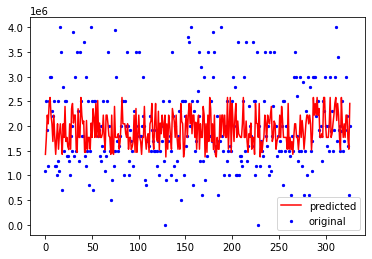

RandomForest Mean squared error:  0.00015987645572096963


In [15]:
RF = RandomForestRegressor(n_estimators=1000,
                            max_depth=7,
                            max_features='auto',
                            verbose=0,
                            random_state=30,
                            min_samples_leaf=6,
                            oob_score=True,
                            min_samples_split=4)
predicted_set, original_set = Get_Score(RF, 'RandomForest')

### KNN

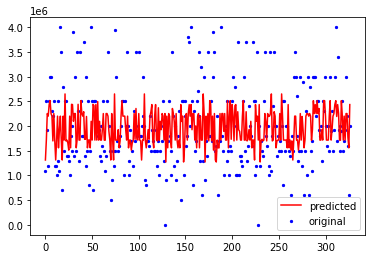

KNN Mean squared error:  0.0001602387687778255


In [16]:
knn = KNeighborsRegressor(n_neighbors=15)
predicted_set, original_set = Get_Score(knn, 'KNN')

### DNN

In [17]:
#Configuring DNN
def build_model():
  model = Sequential([
  Input(shape=(69,)),                  
  Dense(64, activation='relu'),
  Dense(64, activation='relu'),
  Dense(1)
  ], name="MLP_model")

  optimizer = RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model
model = build_model()
model.summary()

Model: "MLP_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4480      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = model.fit(x_train, y_train, epochs=500, verbose=0)

2022-06-29 16:30:41.138322: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-06-29 16:30:41.138467: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


In [19]:
results = model.evaluate(x_test,y_test)
predicted_set = Target_std.inverse_transform(model.predict(x_test).flatten())

11/11 [==============================] - 0s 416us/step - loss: 1.9022e-04 - mae: 0.0107


# Result

In [20]:
predicted_set = pd.DataFrame(data = np.ravel(predicted_set))
original_set = pd.DataFrame(data = np.ravel(original_set))
Result_set = pd.concat([predicted_set,original_set], axis = 1)
Result_set.to_csv('Result.csv')